In [3]:
# https://discuss.pytorch.org/t/i-have-3-gpu-why-torch-cuda-device-count-only-return-1/7245/4
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.8.3 (default, May 19 2020, 18:47:26) 
[GCC 7.3.0]
__pyTorch VERSION: 1.7.0
__CUDA VERSION
/usr/bin/sh: 1: nvcc: not found
__CUDNN VERSION: 8003
__Number CUDA Devices: 2
__Devices
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


In [4]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

import operator as op
from functools import reduce

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data Generation -- Full Matrix

In [3]:
attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    null_card = tuple(['None'] * num_attributes)
    null_card_idx = len(idx_to_card)
    cards.append(null_card)
    idx_to_card[null_card_idx] = null_card
    card_to_idx[null_card] = null_card_idx
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx

def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts

def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.product(cards, repeat=2):
        if 'None' not in card1 and 'None' not in card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print('Number of cardpairs per shared concept', Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair

def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
    
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
                
    for cardpair in cardpairs_without_shared_concepts:
        all_matches.append((cardpair_to_idx[cardpair[0]], len(cards)-1))
        cardpair_to_matches[cardpair_to_idx[cardpair[0]]][len(cards)-1] = 0
        number_of_shared_concepts_per_match.append(0)
                
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of matches per key concept hit = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'num_attributes': num_attributes,
        'num_attr_vals': num_attr_vals,
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'query_support_size': len(idx_to_cardpair),
        'key_support_size': len(idx_to_card),
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data

In [4]:
def get_count_table(game_data):
    count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
    for q, k in game_data['all_matches']:
        count_table[k, q] += 1
    return count_table

def get_distribution(count_table, distribution_epsilon=0.0):
    xy = count_table/np.sum(count_table)
    xy += distribution_epsilon
    xy /= np.sum(xy)
    x = np.sum(xy,0)
    y = np.sum(xy,1)
    xyind = y[None].T @ x[None]
    return xy, xyind, xy/xyind

def report_countable_distribution(count_table, distribution_epsilon=0.0):
    sparsity = np.sum(count_table) * 1.0 / (count_table.shape[0] * count_table.shape[1])
    xy, xyind, xy_div_xyind = get_distribution(count_table, distribution_epsilon)
    xy_rank = np.linalg.matrix_rank(xy)
    xy_div_xyind_rank = np.linalg.matrix_rank(xy_div_xyind)
    
    distribution = {
        'shape': xy.shape,
        'size': xy.shape[0] * xy.shape[1],
        'sparsity': sparsity,
        'xy_rank': xy_rank,
        'xy_div_xyind_rank': xy_div_xyind_rank
    }
    
    return count_table, xy, xyind, xy_div_xyind, distribution

def report_gamedata_distribution(game_data, distribution_epsilon=0.0):
    count_table = get_count_table(game_data)
    return report_countable_distribution(count_table, distribution_epsilon=0.0)

def plot_distribution(xy, xy_div_xyind, dist_name, figsize):
    figrange = (0, xy.shape[0], 0, xy.shape[1])
    plt.figure(figsize = figsize)
    plt.title(dist_name+' xy, All {} quries'.format(xy.shape[1]))
    plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])
    plt.figure(figsize = figsize)
    plt.title(dist_name+' xy_div_xyind, All {} quries'.format(xy.shape[1]))
    plt.imshow((xy_div_xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])
    if xy.shape[1] > 300:
        plt.figure(figsize = figsize)
        plt.title(dist_name+' xy, First 300 queries')
        plt.imshow((xy)[figrange[0]:figrange[1], :300])
        plt.title(dist_name+' xy_div_xyind, First 300 queries')
        plt.figure(figsize = figsize)
        plt.imshow((xy_div_xyind)[figrange[0]:figrange[1], :300])

In [5]:
num_attributes = 2
num_attr_vals = 3
game_data_full = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 10 unqiue cards
Generated 81 cardpairs
-- 45 cardpairs with shared concept
-- 36 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 36), (0, 36), (2, 9)]
Total number of matches =  189
Number of matches per key concept hit =  [(1, 144), (0, 36), (2, 9)]


{'shape': (10, 81), 'size': 810, 'sparsity': 0.23333333333333334, 'xy_rank': 10, 'xy_div_xyind_rank': 10}
Full


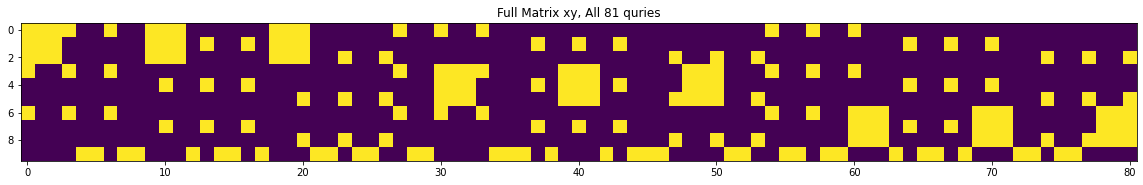

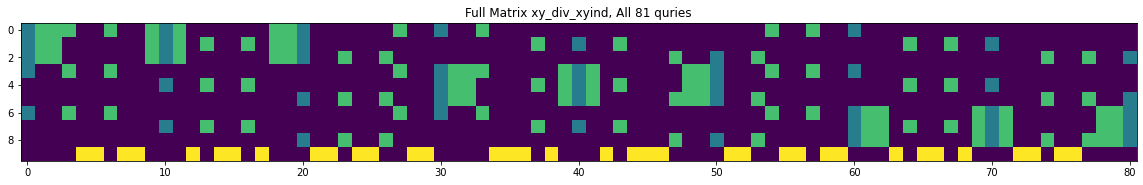

In [6]:
count_table, xy, _, xy_div_xyind, distribution = report_gamedata_distribution(game_data_full, distribution_epsilon=0.0)
print(distribution)
plot_distribution(xy, xy_div_xyind, dist_name='Full Matrix', figsize = (20,15))

## Data Generation -- Sampled

In [7]:
def decode_key_idx(num_attrs, num_attr_vals, card_idx):
    '''
    decode card idx into attr val idx
    '''
    assert card_idx < num_attr_vals ** num_attrs
    ans = []
    if card_idx == num_attr_vals ** num_attrs:
        return np.array(ans)
    else:
        card_idx_copy = card_idx
        for i in range(num_attrs):
            digit = card_idx_copy % num_attr_vals
            ans = [digit] + ans
            card_idx_copy = card_idx_copy // num_attr_vals
        assert len(ans) == num_attrs
        return np.array(ans)

def decode_query_idx(num_attrs, num_attr_vals, query_idx):
    '''decode query_idx into pair of card indices'''
    num_cards = num_attr_vals ** num_attrs
    card1_idx = query_idx // num_cards
    card2_idx = query_idx % num_cards
    return card1_idx, card2_idx

def check_if_query_key_match(query_part1, query_part2, key, debug=False):
    shared_attr_filter_q1q2 = query_part1 == query_part2
    shared_attr_filter_q1k = query_part1 == key
    matches = (shared_attr_filter_q1q2 & shared_attr_filter_q1k) # F, F , T
    num_matches = np.sum(matches) # 1
    if debug: print(query_part1, query_part2, key, num_matches)
    return num_matches

def queryidx_to_querypair(num_attrs, num_attr_vals, query_idx):  
    q1_idx, q2_idx = decode_query_idx(num_attrs, num_attr_vals, query_idx)
    query_part1 = decode_key_idx(num_attrs, num_attr_vals, q1_idx)
    query_part2 = decode_key_idx(num_attrs, num_attr_vals, q2_idx)
    return query_part1, query_part2
    
def check_if_query_key_match_by_idx(num_attrs, num_attr_vals, query_idx, key_idx):
    '''return an int'''
    query_part1, query_part2 = queryidx_to_querypair(num_attrs, num_attr_vals, query_idx)
    return check_q1q2k_match(num_attrs, num_attr_vals, query_part1, query_part2, key_idx)

def check_q1q2k_match(num_attrs, num_attr_vals, query_part1, query_part2, key_idx):
    if key_idx == num_attr_vals ** num_attrs: # null key card
        if not (query_part1 == query_part2).any():
            return 1
        else:
            return 0
    else: # key card with real values
        key = decode_key_idx(num_attrs, num_attr_vals, key_idx)
        num_matched_attributes = check_if_query_key_match(query_part1, query_part2, key)
        return num_matched_attributes 

def query_has_real_matches(query_part1, query_part2):
    return (query_part1 == query_part2).any()

def query_idx_has_real_matches(num_attrs, num_attr_vals, query_idx):
    query_part1, query_part2 = queryidx_to_querypair(num_attrs, num_attr_vals, query_idx)
    return query_has_real_matches(query_part1, query_part2)
    
def sample_query_key_idx(num_attrs, num_attr_vals):
    num_keys = num_attr_vals ** num_attrs
    num_queries = num_keys * num_keys
    key_idx = np.random.choice(num_keys + 1)
    query_idx = np.random.choice(num_queries)
    return query_idx, key_idx
    
def sample_valid_query_key_idx(num_attrs, num_attr_vals):
    valid = False
    trials = 0
    while not valid:
        tmp_query_idx, tmp_key_idx = sample_query_key_idx(num_attrs, num_attr_vals)
        valid = check_if_query_key_match_by_idx(num_attrs, num_attr_vals, tmp_query_idx, tmp_key_idx)
        if valid: valids = (tmp_query_idx, tmp_key_idx)
        trials += 1
    return trials, valids

def sample_N_datapoints(num_attrs, num_attr_vals, N):
    all_valids = []
    cts = 0
    for i in range(N):
        trials, valids = sample_valid_query_key_idx(num_attrs, num_attr_vals)
        cts += trials
        all_valids.append(valids)
    print('Sparsity Estimate:', 1/(cts / N))
    return all_valids
    
def test_sampling():

    for i in range(10000):
        q, c = sample_query_key_idx(num_attrs=4, num_attr_vals=3)
        assert c < 81 and q < 3240

    sample_N_datapoints(num_attrs, num_attr_vals, N) # should be around 0.184471

    
def sample_dataset(num_attrs, num_attr_vals, N_train, N_val):
    
    N = N_train + N_val
    datapoints = sample_N_datapoints(num_attrs, num_attr_vals, N)
        
    data = {
        'num_attributes':num_attrs,
        'num_attr_vals':num_attr_vals,
        'key_support_size': num_attr_vals**num_attrs + 1,
        'query_support_size': (num_attr_vals**num_attrs)**2,
        'train_datapoints': datapoints[:N_train],
        'val_datapoints': datapoints[N_train:N_train+N_val]
    }
    
    return data

In [8]:
game_data_sampled = sample_dataset(num_attributes, num_attr_vals, N_train=10000, N_val=1000)

Sparsity Estimate: 0.2338733682017264


## Dataset

In [9]:
class GameDatasetFromFullMatrix():
    '''Directly sample from full distribution matrix'''
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        self.num_attrs = self.raw_data['num_attributes']
        self.num_attr_vals = self.raw_data['num_attr_vals']
        self.query_support_size = self.raw_data['query_support_size'] # y
        self.key_support_size = self.raw_data['key_support_size'] # x
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

num_attributes = 2
num_attr_vals = 3
game_data_full = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------------------------------------------------------')
game_dataset = GameDatasetFromFullMatrix(raw_data=game_data_full, debug=True)
game_dataset[50] 

Generated 10 unqiue cards
Generated 81 cardpairs
-- 45 cardpairs with shared concept
-- 36 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 36), (0, 36), (2, 9)]
Total number of matches =  189
Number of matches per key concept hit =  [(1, 144), (0, 36), (2, 9)]
------------------------------------------------------------------------
query
 50 : 5 5 ('green', 'solid') ('green', 'solid')
key
 0 ('red', 'void')
all matches 
 [('red', 'solid'), ('green', 'void'), ('green', 'dashed'), ('green', 'solid'), ('blue', 'solid')]


(50, tensor([50]), tensor([0]), tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 0]))

In [10]:
class GameDatasetFromDataPoints(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by sample_dataset()
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        self.num_attrs = self.raw_data['num_attributes']
        self.num_attr_vals = self.raw_data['num_attr_vals']
        self.query_support_size = self.raw_data['query_support_size']
        self.key_support_size = self.raw_data['key_support_size']
        
    def compute_gt(self, query_idx):
        q1_idx, q2_idx = decode_query_idx(self.num_attrs, self.num_attr_vals, query_idx)
        query1 = decode_key_idx(self.num_attrs, self.num_attr_vals, q1_idx)
        query2 = decode_key_idx(self.num_attrs, self.num_attr_vals, q2_idx)
        
        gt = [
            float(check_q1q2k_match(self.num_attrs, self.num_attr_vals, query1, query2, k_idx) > 0) \
            for k_idx in range(self.key_support_size)
        ]
        return np.array(gt)

In [11]:
class GameDatasetTrainDataset(GameDatasetFromDataPoints):
    '''Sample from Presampled Datapoints. Better for Sparse distribution matrix.'''
    
    def __init__(self, raw_data, split, debug=False):
        assert split in ('train', 'val')
        super().__init__(raw_data, debug)
        self.split = split
        
    def __len__(self):
        return len(self.raw_data[self.split + '_datapoints'])
            
    def __getitem__(self, idx):
        '''
        idx: int.
        '''
        # query, key
        y_j, x_i = self.raw_data[self.split + '_datapoints'][idx]
        gt = self.compute_gt(y_j)
           
        if self.debug:
            yj1, yj2 = decode_query_idx(self.num_attrs, self.num_attr_vals, y_j)
            print(
                'query\n', y_j,":", yj1, yj2, 
                decode_key_idx(self.num_attrs, self.num_attr_vals, yj1), 
                decode_key_idx(self.num_attrs, self.num_attr_vals, yj2)
            )
            print('key\n', x_i, decode_key_idx(self.num_attrs, self.num_attr_vals, x_i))
            print('all matches \n', [decode_key_idx(self.num_attrs, self.num_attr_vals, i) for i,v in enumerate(gt) if v == 1.])
                  
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )   
                 
num_attributes = 2
num_attr_vals = 3
game_data_sampled = sample_dataset(num_attributes, num_attr_vals, N_train=10000, N_val=1000)
print('------------------------------------------------------------------------')
game_dataset_sampled = GameDatasetTrainDataset(raw_data=game_data_sampled, split='train', debug=True)
game_dataset_sampled[10]

Sparsity Estimate: 0.23733494433416763
------------------------------------------------------------------------
query
 18 : 2 0 [0 2] [0 0]
key
 2 [0 2]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2])]


(10, tensor([18]), tensor([2]), tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0]))

In [12]:
class GameTestFullDataset(GameDatasetFromDataPoints):
    
    def __init__(self, raw_data, debug=False):
        super().__init__(raw_data, debug)
        
    def __len__(self):
        return self.raw_data['query_support_size']
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        gt = self.compute_gt(y_j)

        if self.debug:
            yj1, yj2 = decode_query_idx(self.num_attrs, self.num_attr_vals, y_j)
            print(
                'query\n', y_j,":", yj1, yj2, 
                decode_key_idx(self.num_attrs, self.num_attr_vals, yj1), 
                decode_key_idx(self.num_attrs, self.num_attr_vals, yj2)
            )
            print('all matches \n', [decode_key_idx(self.num_attrs, self.num_attr_vals, i) for i,v in enumerate(gt) if v == 1.])
                  
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )
    
print('------------------------------------------------------------------------')
game_dataset_sampled = GameTestFullDataset(raw_data=game_data_sampled, debug=True)
game_dataset_sampled[10]

------------------------------------------------------------------------
query
 10 : 1 1 [0 1] [0 1]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2]), array([1, 1]), array([2, 1])]


(10, tensor([10]), tensor([0]), tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 0]))

In [13]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.train_dataset = GameDatasetTrainDataset(raw_data=raw_data, split='train', debug=debug)
        self.val_dataset = GameDatasetTrainDataset(raw_data=raw_data, split='val', debug=debug)
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.train_dataset
            self.val = self.val_dataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=True
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size, shuffle=False
        )
        return val_loader

## Model Architecture

In [14]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [15]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [16]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            raise ValueError('Not supposed to use classifier!')
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

# Loss, Metric

In [17]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [18]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.num_attrs = self.raw_data['num_attributes']
        self.num_attr_vals = self.raw_data['num_attr_vals']
        self.key_support_size = self.raw_data['key_support_size']
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)
        
    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
            check_if_query_key_match_by_idx(
                self.num_attrs, self.num_attr_vals, X_query_list[batch_i].item(), key_idx
            ) for batch_i in range(b) for key_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(self.num_attrs+1)}
        total_count_by_num_matched_concepts = {k:0 for k in range(self.num_attrs+1)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
 
            # filter down to query cards with >0 true matches
            X_query_flat = X_query.squeeze(-1)
            # NOTE: Not great
            fil = torch.tensor(
                [query_idx_has_real_matches(self.num_attrs, self.num_attr_vals, qId.item()) \
                 for qId in X_query_flat
                ]).type_as(X_query).type(torch.bool)            
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = 2 * (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [19]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions={}):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            assert gt_distributions
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        # turn -inf values into zeros, ok because p(x,y) is also zero for those values
        pmi_notInf_mask = torch.isinf(pmi)
        pmi[pmi_notInf_mask] = 0.0
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        print('SELF GT MI', self.gt_mi)
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_gt':self.gt_mi,
            'mi_hat':mi_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [20]:
# arguments
generate_full_matrix = True

In [5]:
# generate on the fly -- becareful of sampling time
# num_attributes = 2
# num_attr_vals = 3
# game_data = sample_dataset(num_attributes, num_attr_vals, N_train=10000, N_val=1000)

# read from disk instead
with open('../Raw_Datasets/2Attr-4Vals-2hat23Train-2hat3Val.json', 'r') as f:
    game_data = json.load(f)

for k in game_data:
    if not 'datapoints' in k:
        print(k,':', game_data[k])

num_attributes 2
num_attr_vals 4
key_support_size 17
query_support_size 256


In [22]:
# read from disk instead
hparams = {
    'seed': 42,
    'batch_size': 128,
    'max_epochs': 50,
    # embedding
    'd_model': 8,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
}


In [23]:
# main() do this only if data is small
if generate_full_matrix:
    game_data_full = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
    count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data_full, distribution_epsilon=0.0)
    gt = {
        'count_table':count_table,
        'xy':xy,
        'xyind':xyind,
        'xy_div_xyind':xy_div_xyind,
        'distribution':distribution
    }
    print(distribution)
else:
    gt = None

Generated 10 unqiue cards
Generated 81 cardpairs
-- 45 cardpairs with shared concept
-- 36 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 36), (0, 36), (2, 9)]
Total number of matches =  189
Number of matches per key concept hit =  [(1, 144), (0, 36), (2, 9)]
{'shape': (10, 81), 'size': 810, 'sparsity': 0.23333333333333334, 'xy_rank': 10, 'xy_div_xyind_rank': 10}


In [24]:
# main()

hparams['key_support_size'] = game_data['key_support_size']
hparams['query_support_size'] = game_data['query_support_size']
hparams['num_attributes'] = game_data['num_attributes']
hparams['num_attr_vals'] = game_data['num_attr_vals']
hparams['populate_logits_matrix'] = generate_full_matrix

pl.seed_everything(42)

# model
thresholded_metrics = ThresholdedMetrics(raw_data=game_data)
trainmodule =  TrainModule(hparams, gt_distributions=gt if hparams['populate_logits_matrix'] else {})
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# dataset
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    debug=hparams['debug']
)

# testloader
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=hparams['debug']), 
            batch_size=hparams['batch_size'], shuffle=False
        )

# logger
run_name = 'CardGame:OR;attr{}-val{};d_model{};{};params{}K'.format(
    num_attributes, num_attr_vals, 
    hparams['d_model'],  
    'dot-product' if hparams['dotproduct_bottleneck'] else '',
    round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling-SecondPass'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)

# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)
os.makedirs(ckpt_dir_PATH, exist_ok=True)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 728   
1  | model.inp_query_layer                        | Sequential         | 648   
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 648   
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 648   
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 80    
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 80    
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 80    
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## run training

In [25]:
# train()
def run_train(trainmodule, datamodule, ckpt_dir_PATH, hparams, wd_logger):

    # checkpoints
    checkpoint_callback = ModelCheckpoint(
        monitor='avg_val_accuracy_by_Query',
        dirpath=ckpt_dir_PATH,
        filename='{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        save_last=True,
        mode='max',
    )

    # trainer
    trainer = pl.Trainer(
        gpus=[1], 
        min_epochs=2, max_epochs=hparams['max_epochs'], 
        precision=32, 
        logger=wd_logger,
        log_gpu_memory='all',
        weights_summary = 'full',
        gradient_clip_val=hparams['gradient_clip_val'],
        callbacks=[checkpoint_callback]
    )

    #fit
    with torch.autograd.detect_anomaly():
        trainer.fit(trainmodule, datamodule)

    wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

In [26]:
# main()
run_train(trainmodule, game_datamodule, ckpt_dir_PATH, hparams, wd_logger)

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory checkpoints/ContrastiveLearning-cardgame-Scaling-SecondPass/CardGame:OR;attr2-val3;d_model8;dot-product;params0.73K exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-25-8819e521c74f>:27: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 728   
1  | model.inp_query_layer                        | Sequential         | 648   
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 648   
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 648   
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 80    
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 80    
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 80    
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                     

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   1%|          | 1/87 [00:00<00:06, 13.31it/s, loss=622, v_num=upgc]

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  91%|█████████ | 79/87 [00:04<00:00, 16.89it/s, loss=589, v_num=upgc]
Validating: 0it [00:00, ?it/s]
Epoch 1:  92%|█████████▏| 80/87 [00:04<00:00, 17.05it/s, loss=580, v_num=upgc]
Validating: 0it [00:00, ?it/s]
Epoch 2:  92%|█████████▏| 80/87 [00:04<00:00, 17.33it/s, loss=563, v_num=upgc]
Validating: 0it [00:00, ?it/s]
Epoch 3:  92%|█████████▏| 80/87 [00:04<00:00, 16.98it/s, loss=539, v_num=upgc]
Validating: 0it [00:00, ?it/s]
Epoch 4:  92%|█████████▏| 80/87 [00:04<00:00, 17.34it/s, loss=516, v_num=upgc]
Validating: 0it [00:00, ?it/s]
Epoch 5:  92%|█████████▏| 80/87 [00:04<00:00, 16.97it/s, loss=497, v_num=upgc]
Validating: 0it [00:00, ?it/s]
Epoch 6:  92%|█████████▏| 80/87 [00:04<00:00, 16.80it/s, loss=482, v_num=upgc]
Validating: 0it [00:00, ?it/s]
Epoch 7:  92%|█████████▏| 80/87 [00:04<00:00, 17.70it/s, loss=475, v_num=upgc]
Validating: 0it [00:00, ?it/s]
Epoch 8:  92%|█████████▏| 80/87 [00:04<00:00, 16.83it/s, loss=467, v_num=upgc]
Validating: 0it [00:00, ?it/s]
Epoch 9:  

Epoch 48:  92%|█████████▏| 80/87 [00:04<00:00, 17.40it/s, loss=443, v_num=upgc]
Validating: 0it [00:00, ?it/s]
Epoch 49:  92%|█████████▏| 80/87 [00:04<00:00, 17.40it/s, loss=443, v_num=upgc]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 87/87 [00:04<00:00, 17.55it/s, loss=443, v_num=upgc]
                                                         

Saving latest checkpoint...


Epoch 49: 100%|██████████| 87/87 [00:05<00:00, 17.30it/s, loss=443, v_num=upgc]


## run testing

In [28]:
def run_test(ckpt_name, project_name, run_Id, gt, test_loader, trainmodule, datamodule, ckpt_dir_PATH, hparams, wd_logger, gpu, figsize=(10,15)):

    checkpoint_PATH = os.path.join(ckpt_dir_PATH, ckpt_name) #'last.ckpt'
    run_PATH = os.path.join(project_name, run_Id) # e.g. 'tki26w1t' also from wandb interface

    wandb.restore(checkpoint_PATH, run_path=run_PATH)
    checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
    trainmodule.load_state_dict(checkpoint['state_dict'])

    trainer = pl.Trainer(
        gpus=[gpu], 
        min_epochs=1, max_epochs=1, 
        precision=32, 
        logger=wd_logger,
        log_gpu_memory='all',
        weights_summary = 'full',
        gradient_clip_val=hparams['gradient_clip_val'],
    )
    
    test_loader = DataLoader(
                GameTestFullDataset(raw_data=game_data, debug=True), 
                batch_size=hparams['batch_size'], shuffle=False
            )
    
    res = trainer.test(model=trainmodule, test_dataloaders=test_loader)
    
    if hparams['populate_logits_matrix']:  
        model_distribution_res = trainmodule.pull_model_distribution(debug=hparams['debug'])
        print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
        print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
        print('mi_hat:', model_distribution_res['mi_hat'])
        print('mi_gt:', model_distribution_res['mi_gt'])
        print('kl_div:', model_distribution_res['kl_div'])
        
        plot_distribution(model_distribution_res['xy_hat'], model_distribution_res['xy_div_xyind_hat'], 'Model', figsize)
        plot_distribution(gt['xy'], gt['xy_div_xyind'],'Ground-Truth', figsize)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


query
 0 : 0 0 [0 0] [0 0]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2]), array([1, 0]), array([2, 0])]
query
 1 : 0 1 [0 0] [0 1]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2])]
query
 2 : 0 2 [0 0] [0 2]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2])]
query
 3 : 0 3 [0 0] [1 0]
all matches 
 [array([0, 0]), array([1, 0]), array([2, 0])]
query
 4 : 0 4 [0 0] [1 1]
all matches 
 ['']
query
 5 : 0 5 [0 0] [1 2]
all matches 
 ['']
query
 6 : 0 6 [0 0] [2 0]
all matches 
 [array([0, 0]), array([1, 0]), array([2, 0])]
query
 7 : 0 7 [0 0] [2 1]
all matches 
 ['']
query
 8 : 0 8 [0 0] [2 2]
all matches 
 ['']
query
 9 : 1 0 [0 1] [0 0]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2])]
query
 10 : 1 1 [0 1] [0 1]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2]), array([1, 1]), array([2, 1])]
query
 11 : 1 2 [0 1] [0 2]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2])]
query
 12 : 1 3 [0 1] [1 0]
all matches 
 ['']
query
 13 :

<ipython-input-18-a4beacb88efb>:67: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  fil = torch.tensor(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_NullQueries_accuracy_by_Query': 1.0,
 'avg_test_NullQueries_accuracy_by_QueryKey': 1.0,
 'avg_test_NullQueries_error_rate_for_0_matched_concepts': 0.0,
 'avg_test_NullQueries_error_rate_for_1_matched_concepts': 0.0,
 'avg_test_NullQueries_f1_by_Query': 1.0,
 'avg_test_NullQueries_f1_by_QueryKey': 1.0,
 'avg_test_NullQueries_precision_by_Query': 1.0,
 'avg_test_NullQueries_precision_by_QueryKey': 1.0,
 'avg_test_NullQueries_recall_by_Query': 1.0,
 'avg_test_NullQueries_recall_by_QueryKey': 1.0,
 'avg_test_NullQueries_total_count_for_0_matched_concepts': 324.0,
 'avg_test_NullQueries_total_count_for_1_matched_concepts': 36.0,
 'avg_test_accuracy_by_Query': 0.9975309371948242,
 'avg_test_accuracy_by_QueryKey': 0.9975309371948242,
 'avg_test_error_rate_for_0_matched_concepts': 0.0,
 'avg_test_error_rate_for_1_matched_concepts': 0.011111111111111112,
 'avg_test_f1_by_Query'

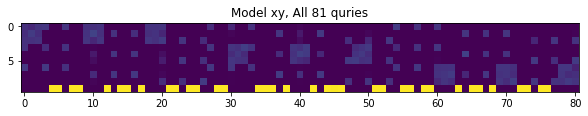

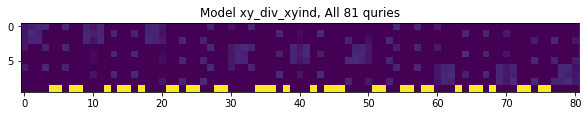

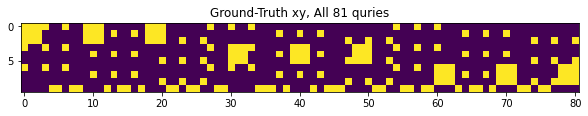

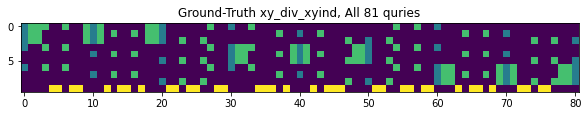

In [29]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )

run_test('last.ckpt', project_name, '2613upgc', gt, test_loader, trainmodule, game_datamodule, ckpt_dir_PATH, hparams, wd_logger, gpu=0, figsize=(10,15))